In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max (len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words/names
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length, time dimension, how many characters we can look at to predict the next one

def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * block_size

        for c in word + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr,    Ytr   = build_dataset(words[:n1])   # 80% - training set
Xdev,   Ydev  = build_dataset(words[n1:n2]) # 10% - validation / development set
Xte,    Yte   = build_dataset(words[n2:])   # 10% - test set


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), " ---> ", itos[y.item()])

........  --->  y
.......y  --->  u
......yu  --->  h
.....yuh  --->  e
....yuhe  --->  n
...yuhen  --->  g
..yuheng  --->  .
........  --->  d
.......d  --->  i
......di  --->  o
.....dio  --->  n
....dion  --->  d
...diond  --->  r
..diondr  --->  e
.diondre  --->  .
........  --->  x
.......x  --->  a
......xa  --->  v
.....xav  --->  i
....xavi  --->  e


In [7]:
# Near copy paste of the layer we developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights

        if self.bias is not None:
            self.out += self.bias
        
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training =True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self, x):
        # Fixing WaveNet dimensions
        if self.training:
            if x.dim() == 2:
                dim = 1
            elif x.dim() == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)   # batch mean      # (32,4,68) -> (1,1,68)
            xvar = x.var(dim, keepdim=True)     # batch variance  # (32,4,68) -> (1,1,68)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        # Broadcasting phase
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize
        # x:     (32, 4, 68)
        # xmean: (1,  1, 68) -> broadcasts to (32,4,68)
        # xvar:  (1,  1, 68) -> broadcasts to (32,4,68)
        
        self.out = self.gamma * xhat + self.beta

        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, vocab_size, emb_dim):
        self.weight = torch.randn((vocab_size, emb_dim))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n_embed2concat):
        self.n_embed2concat = n_embed2concat # number of embeddings to concatenate
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n_embed2concat, C * self.n_embed2concat)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42) # for reprducibility

In [9]:
# hierarichal network
n_embed = 24
n_hidden = 128
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weights *= 0.1 # makes the last layer less confident, since Linear without batchnorm make it too confidently wrong

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [10]:
# the same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i< 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d} | loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000 | loss: 3.3040
  10000/ 200000 | loss: 2.1067
  20000/ 200000 | loss: 1.9967
  30000/ 200000 | loss: 2.5353
  40000/ 200000 | loss: 2.1573
  50000/ 200000 | loss: 1.6786
  60000/ 200000 | loss: 2.1719
  70000/ 200000 | loss: 1.9447
  80000/ 200000 | loss: 1.7272
  90000/ 200000 | loss: 2.0578
 100000/ 200000 | loss: 1.7405
 110000/ 200000 | loss: 1.9316
 120000/ 200000 | loss: 1.7479
 130000/ 200000 | loss: 1.8406
 140000/ 200000 | loss: 1.6387
 150000/ 200000 | loss: 1.8883
 160000/ 200000 | loss: 1.7816
 170000/ 200000 | loss: 1.5509
 180000/ 200000 | loss: 1.5115
 190000/ 200000 | loss: 1.8976


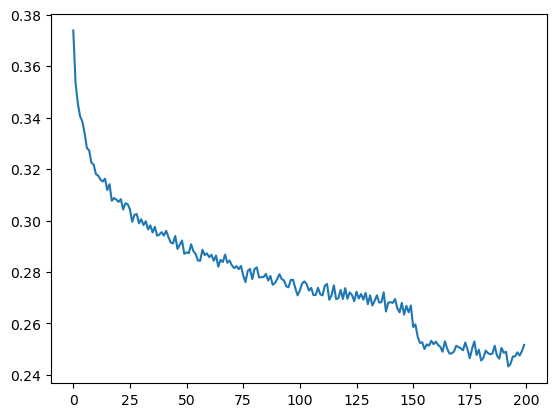

In [13]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [14]:
# put layerrs in eval mode (needed for BatchNorm especially)
for layer in model.layers:
    layer.training = False

In [18]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

RuntimeError: The size of tensor a (182625) must match the size of tensor b (32) at non-singleton dimension 0